In [1]:
### Defining Environment variables pointing to user folders
from os import environ

environ['MODEL_STORAGE'] = "/workarea/local/shared/scapelli/"
environ['INPUT_MODEL'] = environ['MODEL_STORAGE']+"/models/efficiency/saved_model.pb"
environ['NB_EXPORT'] = "True" # whether export notebooks

# Validation of the efficiency model
##### Tested on environment `LHCb Analysis Facility` from [landerlini/lhcbaf:v0p8](https://hub.docker.com/r/landerlini/lhcbaf)

This notebook is part of the pipeline to model the acceptance of charged particles in LHCb.
In particular, it requires:
 * the preprocessing step, defined in the [Preprocessing.ipynb](./Preprocessing.ipynb) notebook
 * the training step, defined in the [Efficiency.ipynb](./Efficiency.ipynb) notebook.


## Libraries and environment
As for the validation of the acceptance model, this notebooks relies on GPUs to speed up selection, binning and histogramming operations to perform the validation.
As for the acceptance validation, we rely on [`cupy`](https://cupy.dev) for the numerical computations on GPU, on [`dask`](https://docs.dask.org/en/stable/dataframe.html) to stream data from disk to CPU RAM, and on [`cudf`](https://docs.rapids.ai/api/cudf/stable/) to stream data from CPU RAM to GPU RAM. As there are conflicting dependencies in `cudf` and `tensorflow` for GPU, in this notebook we will perform the evaluation of the trained model on CPU, without any significant loss in performance.

Once again, with the current amount of data, using the GPU is not strictly needed, but we plan to extend the training dataset in the next future and then we may have some benefit (and if not, it would be very interesting to understand why).

Please refer to the discussion in the [Acceptance-validation notebook](./Acceptance-validation.ipynb) for further details.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as ddf
import cudf
import cupy as cp
from os import environ
import os.path

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data
The data needed for the measurement of the performance of the trained algorithm is stored in the [preprocessing step](./Preprocessing.ipynb) and is never loaded in the training notebook to avoid data leaks. Hence, it can be considered as completely independent of the training dataset.

As in other notebooks, we are using our custom implementation of [FeatherReader](./feather_io.py) able to load chunks of data from disk and stream them in the form of either a TensorFlow dataset or, in this case, as a dask dataframe.

In [3]:
from feather_io import FeatherReader
data_reader = FeatherReader(environ.get("TEST_DATA", "efficiency-test"))
test_dataset = data_reader.as_dask_dataframe()

## Load the preprocessing step
The preprocessing step was defined in the [preprocessing notebook](./Preprocessing.ipynb) and was stored in the same folder as the trained model.
The serialization relies on `pickle`.

In [4]:
import pickle
import os.path
model_dir = os.path.dirname(environ.get("INPUT_MODEL", "/workarea/local/shared/scapelli/models/efficiency/saved_model.pb"))
preprocessing_file = os.path.join(model_dir, "tX.pkl")
with open(preprocessing_file, 'rb') as f:
    preprocessing_step = pickle.load(f)

## Load the model

The model was stored in the [training notebook](./Efficiency.ipynb) with the standard keras APIs.
We print a summary of the model to standard output to document the details of the model we are validating.

In [5]:
from IPython.display import HTML
display (HTML(f"Loading model from {model_dir}"))
efficiency_model = tf.keras.models.load_model(model_dir)
efficiency_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1664        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 128)          0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

## Transform data and evaluate the model in a pipeline

The following code block defines a pipeline for:
 * reading a chunk of data from disk using [`FeatherReader`](./feather_io.py);
 * process the chunk of data on CPU applying the inverse preprocessing transform and evaluating the trained neural network model;
 * load the chunk of data to GPU memory for further processing

In [6]:
from validation_utils import invert_column_transformer

def process_batch(batch, preprocessor, features, labels):
    pX = batch[features].values
    batch[features] = invert_column_transformer(preprocessor, pX)

    batch[[f'predicted_{y}' for y in labels]] = efficiency_model.predict(pX, batch_size=len(pX), verbose=False)
    
    return batch


from functools import partial
my_process_batch = partial(process_batch, 
                        features=data_reader.features, 
                        labels=data_reader.labels, 
                        preprocessor=preprocessing_step
                       )

cdf = (
    ddf
    .map_partitions(my_process_batch, test_dataset)
    .map_partitions(cudf.DataFrame.from_pandas)
)
cdf

INFO:tensorflow:Assets written to: ram://8d54bbda-27c1-49ac-bfa2-c4c9b6e937cb/assets


,mc_x,mc_y,mc_z,mc_log10_p,mc_tx,mc_ty,mc_eta,mc_phi,mc_is_e,mc_is_mu,mc_is_h,mc_charge,not_recoed,recoed_as_long,recoed_as_upstream,recoed_as_downstream,predicted_not_recoed,predicted_recoed_as_long,predicted_recoed_as_upstream,predicted_recoed_as_downstream
npartitions=3,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Validation of the averaged efficiency

As a first step in the validation, we compare the overall reconstruction efficiency for each combination of particle type and track class.

As a reminder, the particles we are considering are:
 * Hadrons,
 * Muons,
 * Electrons.
 
While the track classes are:
 * Long tracks,
 * Upstream tracks,
 * Downstream tracks.
 
Please refer to the [Preprocessing notebook](./Preprocessing.ipynb) for additional discussion on this choice.

For each of the nine combinations of particle and track class, we compare the overall efficiency averaged on the whole sample, on the sample obtained from detailed simulation and from the model.
If the training was successful, we should see excellent agreement between the two.

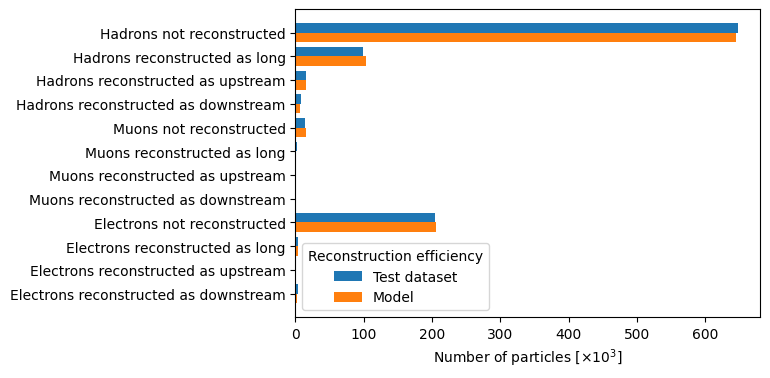

In [7]:
head = cdf.head(1_000_000, npartitions=-1)

height = 0.8

plt.figure(figsize=(6,4))
labels = data_reader.labels
parts = ['h', 'mu', 'e']
n_classes = len(labels)
n_parts = len(parts)
xAxis = -np.arange(n_classes * n_parts)

def count(part, label):
    return head.query(f"mc_is_{part} == 1")[label].sum()/1e3


plt.barh(xAxis + height/4, [count(p, lb) for p in parts for lb in labels], height=height/2, label="Test dataset")
plt.barh(xAxis - height/4, [count(p, f'predicted_{lb}') for p in parts for lb in labels], height=height/2, label="Model")

part_name = dict(h='hadrons', mu='muons', e='electrons')
ticks = [f"{part_name[p]}_{lb}".replace("_", " ").replace("recoed", "reconstructed").capitalize() for p in parts for lb in labels]
plt.yticks(xAxis, ticks)
plt.legend(title="Reconstruction efficiency")
plt.xlabel(r"Number of particles [$\times 10^3$]")
plt.show()

## Validation in kinematic bins

Then we split the sample in kinematic bins to evaluate the quality of the agreement between the model and the test data sample.
To perform this analysis we may need some additional variables, computed combining the features used for training. In the following code block we complete the dataset adding these variables to the dataframe.

In [8]:
def compute_momentum(df):
    df['mc_p'] = 10**df['mc_log10_p']
    df['mc_pz'] = (df.mc_p**2 / (1 + df.mc_tx**2 + df.mc_ty**2))**0.5
    df['mc_px'] = df.mc_pz * df.mc_tx
    df['mc_py'] = df.mc_pz * df.mc_ty
    df['mc_pt'] = (df.mc_px**2 + df.mc_py**2)**0.5
    return df

def compute_eta(df):    
    mc_theta = cp.arcsin(df.mc_pt/df.mc_p)
    df['mc_eta'] = -cp.log(cp.tan(mc_theta/2))
    return df

def compute_phi(df):
    df['mc_phi'] = cp.arctan2(df.mc_py, df.mc_px)
    return df
    

cdf = (cdf.map_partitions(compute_momentum)
       # .map_partitions(compute_eta)
       # .map_partitions(compute_phi)
      )

## Validation plots

The following **stacked histograms** represent the probability for a generated particle in acceptance to be reconstructed as long, upstream or downstream tracks. The different track types are stacked up to the histrogram representing the whole, unselected sample.

As usual, the other histograms are obtained either:
 * selecting particles based on the reconstruction track class as obtained from detailed simulation; or
 * weighing the input particles according to the predictions of the trained model. 

Different particle types are represented in different rows, while different momentum bins are represented in different rows. 

In [9]:
def draw_validation_plots(variable: str, var_title: str, axisdef: tuple, yscale: str = 'linear'):    
    p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

    for part in 'h', 'mu', 'e':
        retain = (
            [variable, 'mc_log10_p'] 
            + [f for f in data_reader.features if f.startswith("mc_is")]
            + data_reader.labels 
            + [f"predicted_{lb}" for lb in data_reader.labels]
        )

        part_name = dict(h='Hadrons', mu='Muons', e='Electrons')[part]
        plt.figure(figsize=(27,3))
        for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
            part_df = (
                cdf[retain]
                .query(" and ".join([
                    f"(mc_is_{part})",
                    f"({variable} > {axisdef[0]:.5f}) and ({variable} < {axisdef[1]:.5f})",
                    f"(mc_log10_p > {np.log10(p_min)} and mc_log10_p < {np.log10(p_max)})"
                    ]))
                .compute()
            )
            plt.subplot(1, len(p_boundaries)-1, iPlot)

            contents, bins = cp.histogram(part_df[variable].values, bins=cp.linspace(*axisdef))
            steps = ['all_parts', 'not_recoed', 'recoed_as_long', 'recoed_as_upstream']
            histos = dict(all_parts=contents.get())
            for step in steps[1:]:
                contents -= cp.histogram(part_df.query(f"{step} == 1")[variable].values, bins=bins)[0]
                histos[step] = contents.get()

            contents, bins = cp.histogram(part_df[variable].values, bins=bins, weights=cp.ones(len(part_df), dtype=np.float64))

            predicted_histos = dict()
            for step in steps[1:]:
                contents -= cp.histogram(part_df[variable].values, bins=bins, weights=part_df[f'predicted_{step}'].values)[0]
                predicted_histos[step] = contents.get()


            xAxis = 0.5*(bins[:-1] + bins[1:]).get()
            labels = dict(
                all_parts="Generated", 
                not_recoed="Long", 
                recoed_as_long="Upstream", 
                recoed_as_upstream="Downstream"
            )
            colors = dict(
                all_parts=("#aee", "#00a"), 
                not_recoed=("#c88", "#a00"), 
                recoed_as_long=("#88c", "#00a"),
                recoed_as_upstream=("#afa", "#080"),
            )
            for step in steps:
                histo_true = histos[step] 
                label = labels[step]
                hue_true, hue_pred = colors[step]
                plt.hist(xAxis, bins=bins.get(), weights=histo_true, label=label, color=hue_true)
                if step not in predicted_histos.keys(): continue 
                histo_pred = predicted_histos[step] 
                plt.hist(xAxis, bins=bins.get(), weights=histo_pred, histtype='step', linewidth=2, color=hue_pred, label=label+" (model)")


            plt.title (f"$p \in [{p_min/1e3:.1f}, {p_max/1e3:.1f}]$ GeV/$c$")
            plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
            plt.xlabel(var_title)
            plt.xlim(axisdef[0], axisdef[1])
            plt.yscale(yscale)
            if iPlot==len(p_boundaries)-1:
                plt.legend(title="Stacked histograms")

        plt.tight_layout()
        plt.show()

### Histograms binning in pseudorapity 

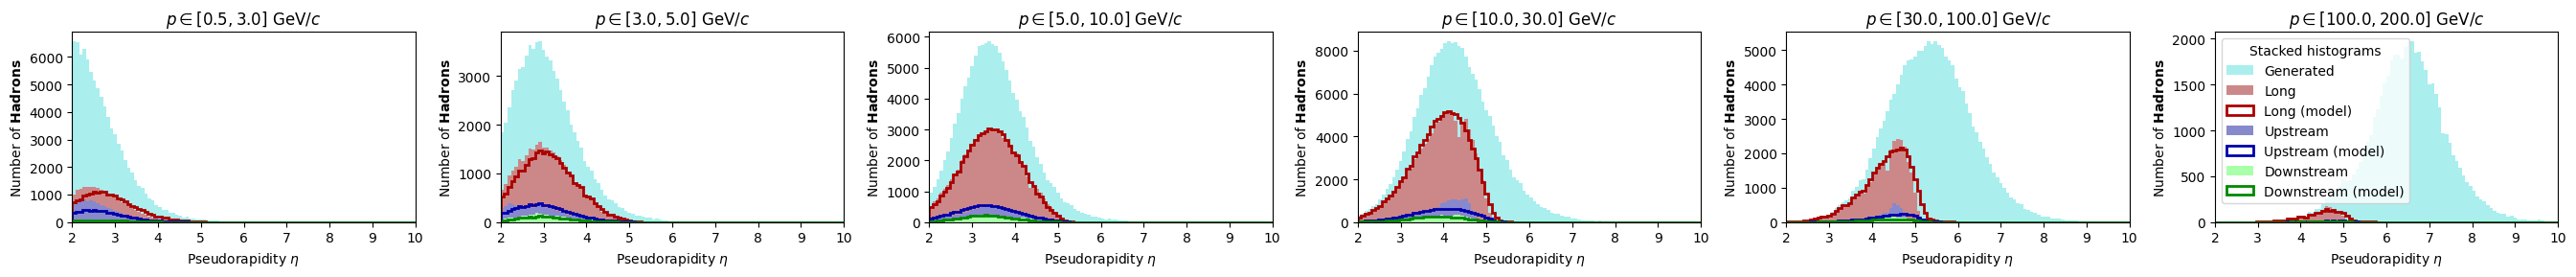

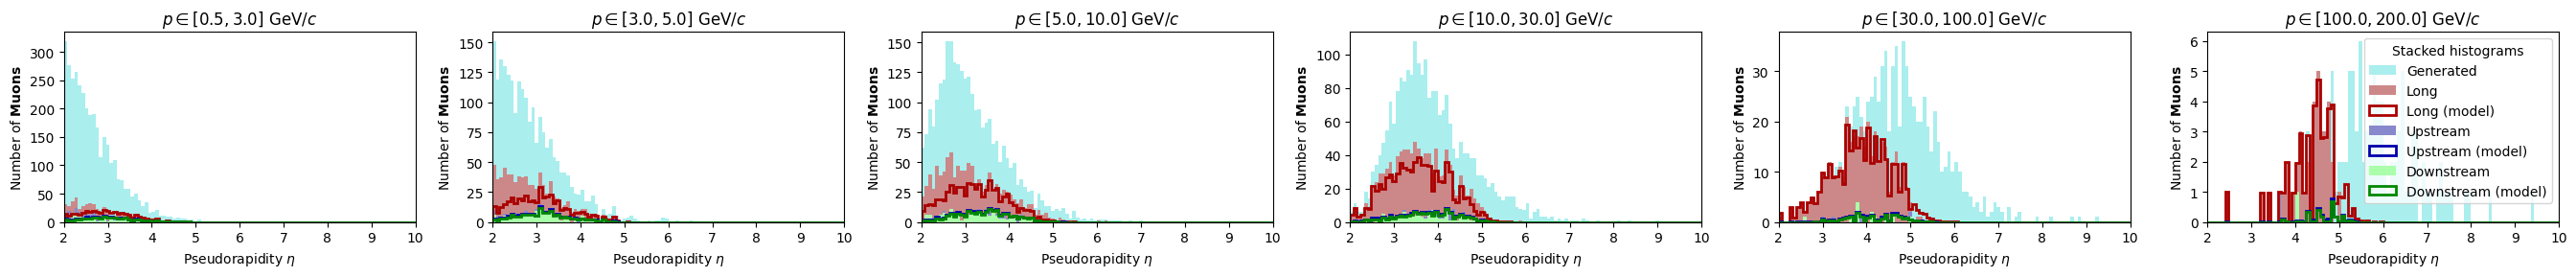

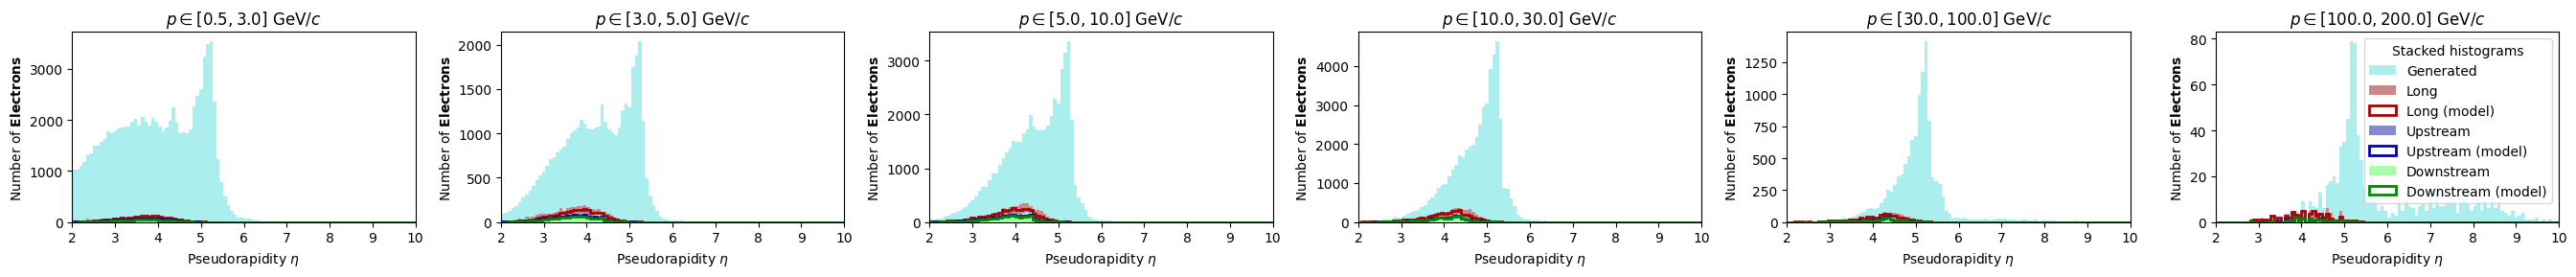

In [10]:
draw_validation_plots("mc_eta", "Pseudorapidity $\eta$", (2., 10., 101), yscale='linear')

### Histograms binning in the $z$ coordinate

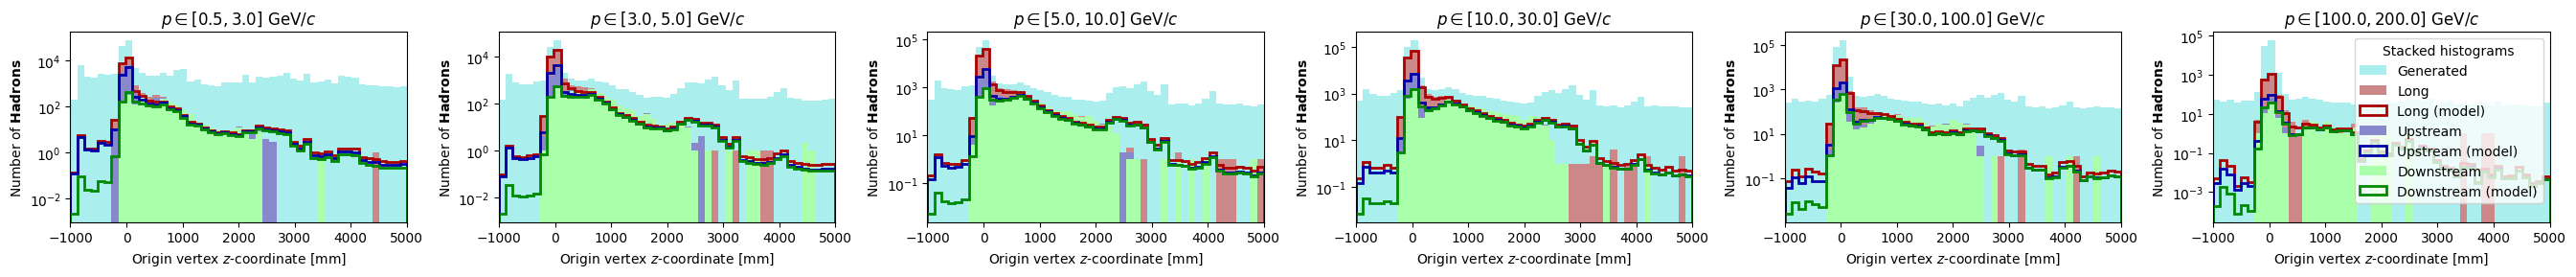

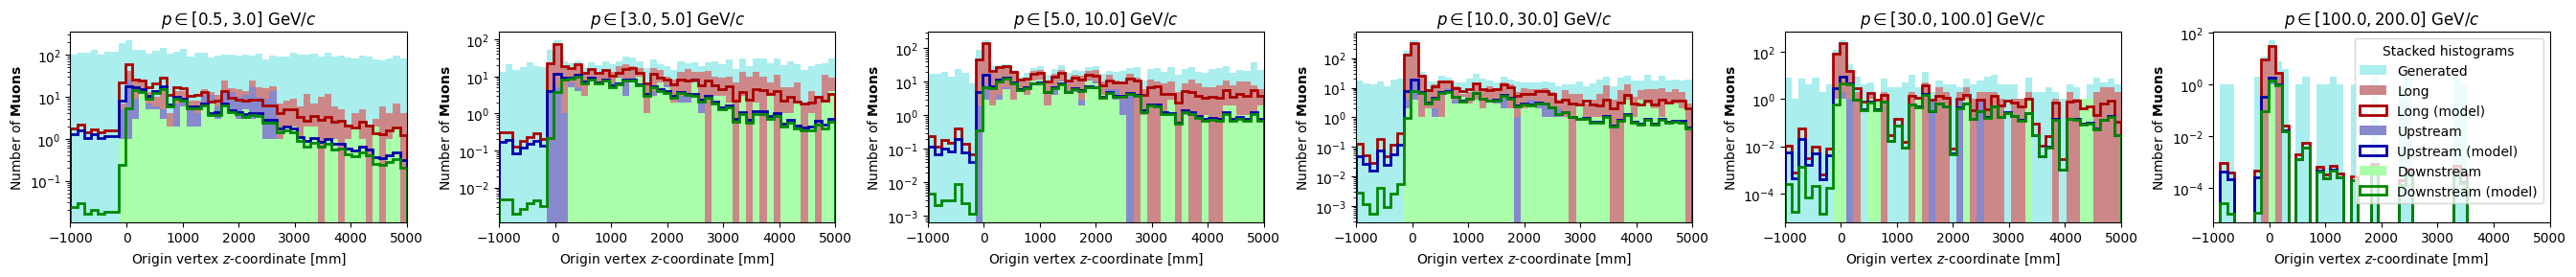

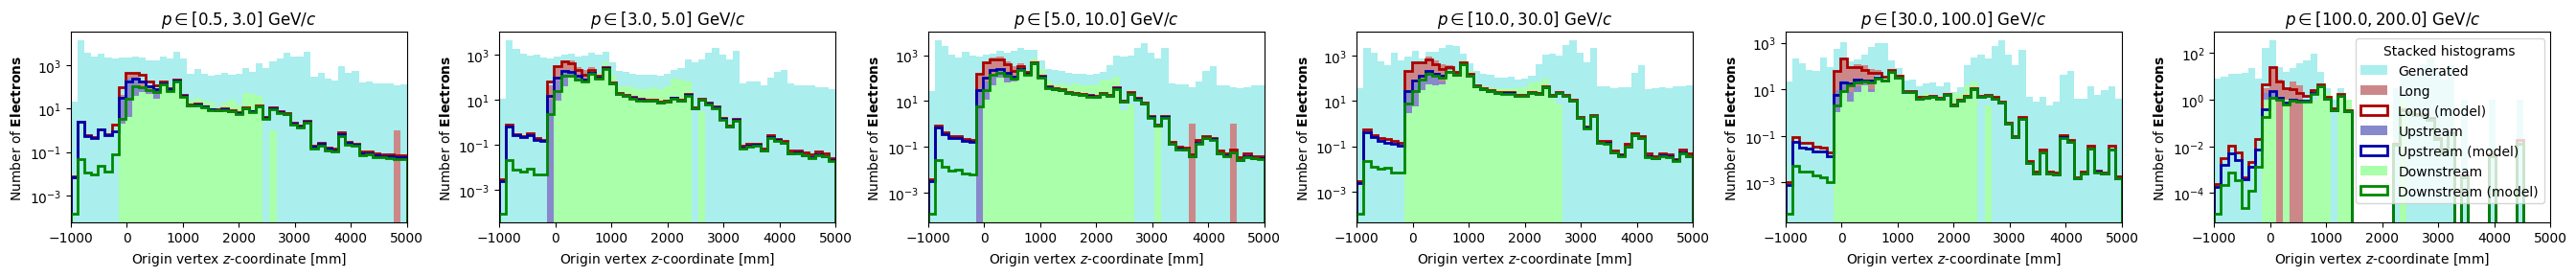

In [11]:
draw_validation_plots("mc_z", "Origin vertex $z$-coordinate [mm]", (-1000., 5000.), yscale='log')

# Conclusion

This notebook describes the validation of the efficiency model, comparing the predicted probability for a particle to be reconstructed as either a long, downstream or upstream track.

The comparison is performed using an independent dataset never seen in the training phase, but statistically equivalent to those used for optimization.

The preprocessing step is inverted and applied to the dataset in order to access the variables as they were before the transformation, recovering their physical meaning.

Comparison of the efficiencies is performed both for the averaged sample and in kinematic bins, showing a decent level of agreement between the model and the detailed simulation.

In [12]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,rename
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Efficiency-validation.ipynb"                            # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Efficiency-validation.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports
